In [1]:
import numpy as np
import math
import timeit
import torch
from torchvision.models.resnet import resnet50
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torch.autograd import Variable
import torch.autograd as autograd

from skvideo.io import VideoCapture

# import matplotlib
# matplotlib.use('TkAgg') 
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
# Visual
class VisualNetwork(torch.nn.Module):
    def __init__(self):
        super(VisualNetwork, self).__init__()
        self.base = resnet50(pretrained=True)
                
    def forward(self, x):
        x = self.base.conv1(x)
        x = self.base.bn1(x)
        x = self.base.relu(x)
        x = self.base.maxpool(x)

        x = self.base.layer1(x)
        x = self.base.layer2(x)
        x = self.base.layer3(x)
        f4 = self.base.layer4(x)

        fpool = F.adaptive_avg_pool2d(f4, 1)
        return fpool, f4

In [3]:
NLSTMOUT = 12

# Temporal LSTM
lstm = torch.nn.LSTM(2048, NLSTMOUT).cuda()

# Initialize the hidden state.
hidden = (autograd.Variable(torch.randn(1, 1, NLSTMOUT).cuda()),
          autograd.Variable(torch.randn((1, 1, NLSTMOUT)).cuda()))

In [4]:
# Define Visual Network
visual_sensor = VisualNetwork()
visual_sensor = visual_sensor.cuda()

<IPython.core.display.Javascript object>


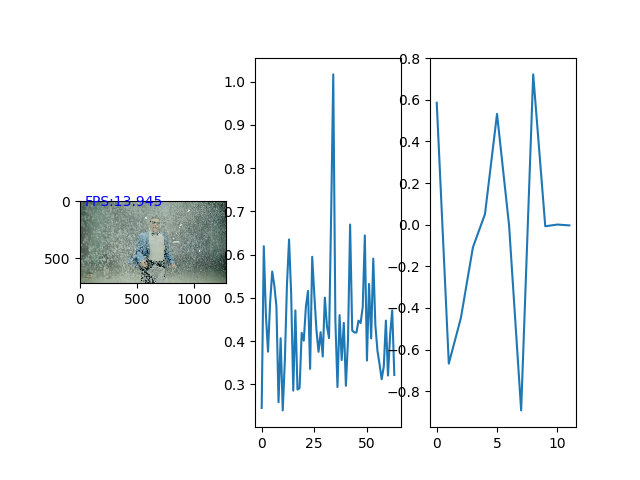

<IPython.core.display.Javascript object>


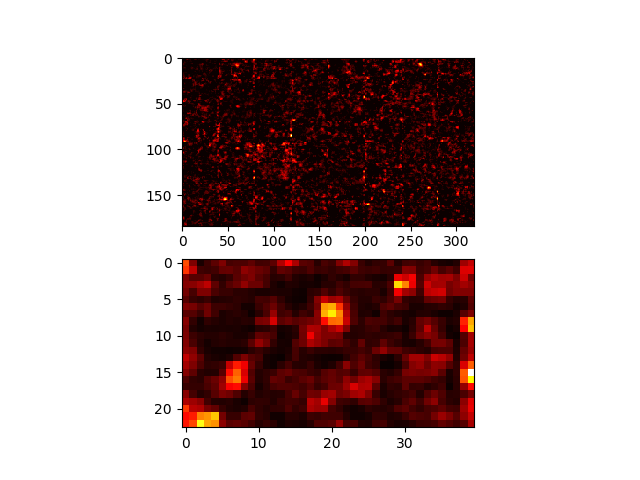

KeyboardInterrupt: 

In [24]:
def np_to_tensor(nparray):
    x = image.astype('float')
    x.transpose((2, 0, 1))    
    x = ToTensor()(x)

    x -= 0.5
    return x.cuda()

def visualize_feats(feats, n=256):
    s1, s2 = feats.shape[-2:]  # feature map size
    nsq = math.floor(math.sqrt(n))
    
    composed = np.zeros((nsq * s1, nsq * s2))    
    for iy in range(nsq):
        for ix in range(nsq):            
            composed[iy*s1:(iy+1)*s1, ix*s2:(ix+1)*s2] = feats[ix+iy*nsq, ...]
            
    att = np.squeeze(np.sum(feats ** 2, axis=0) / feats.shape[0])
    
    return composed, att

# fname = '/home/siqi/Downloads/SampleVideo_360x240_30mb.mp4'
fname = '/home/siqi/repo/Tylor/PSY - GANGNAM STYLE(강남스타일) MV.mp4'
cap = VideoCapture(fname)
cap.open()

f1, ax1 = plt.subplots(1,3)
f2, ax2 = plt.subplots(2,1)

plt.ion()

SKIP = 5
BUFFSZ = 4
NFEATTOSHOW=64
visualize = True
image_buffer = [0]*BUFFSZ
buffer = None

FPS = 0
t_buffer_start = timeit.default_timer()

bufferidx = 0
frameidx = 0
while True:    
    retval, image = cap.read()
        
    if not retval:
        break
    
    if buffer is None:
        buffer = torch.FloatTensor(BUFFSZ, 3, image.shape[0], image.shape[1]).cuda()
    
    if frameidx % SKIP is not 0:
        frameidx += 1
        continue
    else:
        frameidx += 1
        # Fill the buffer
        x = np_to_tensor(image)        
        image_buffer[bufferidx] = image
        buffer[bufferidx,:,:,:] = x
        bufferidx +=1
            
    if bufferidx < BUFFSZ:
        continue
         
    fpool, f4 = visual_sensor(Variable(buffer, volatile=True))    
        
    if visualize:
        vcode = fpool.data[:,:NFEATTOSHOW,:,:].cpu() # For inspection
        f4 = f4.data[:,:NFEATTOSHOW,:,:].cpu().numpy() # For inspection        
        
        for b in range(BUFFSZ):
            lstm_out, hidden = lstm(fpool[b, ...].view(1, 1, -1), hidden)
            lstm_out = lstm_out.data[0, 0, :NFEATTOSHOW].cpu().numpy() # For inspection
            
            ax1[0].cla()
            ax1[1].cla()
            ax1[2].cla()
            ax2[0].cla()
            ax2[1].cla()
            frame = image_buffer[b]
            code = vcode[b,:,:,:].squeeze().cpu().numpy()
            
            try:
                ax1[0].imshow(frame)
            except TypeError:
                print(frame)
                
            ax1[1].plot(code)
                        
            FPS = 1 / ((timeit.default_timer() - t_buffer_start) / frameidx)
            ax1[0].text(40, 40, 'FPS:%.3f' % FPS, color='b')
            
            ax1[2].plot(lstm_out)            
            feats2show, att = visualize_feats(f4[b, ...], NFEATTOSHOW)
            ax2[0].imshow(feats2show, cmap='hot')
            ax2[1].imshow(att, cmap='hot')
            
            f1.show()
            f2.show()
            f1.canvas.draw()
            f2.canvas.draw() 
    else:
        FPS = 1 / ((timeit.default_timer() - t_buffer_start) / frameidx)
        print('FPS:', FPS)
            
    # Clear the buffer
    bufferidx = 0
    image_buffer = [0]*BUFFSZ
    buffer = torch.FloatTensor(BUFFSZ, 3, image.shape[0], image.shape[1]).cuda()
print('Done')

In [16]:
from pytube import YouTube
f = YouTube('http://youtube.com/watch?v=9bZkp7q19f0').streams.first().download()